Paul Scotti 2022

Change Log:
- v0.0.1: Cast inputs to TensorDatasets and style GAN to tensors, specify a data dir, can use gdrive for h5 files (Jimmie Goode)

In [1]:
!python --version

Python 3.9.13


In [2]:
!nvidia-smi

Thu Nov  3 21:18:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   36C    P8    21W / 300W |      5MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   

In [3]:
#!pip freeze > /content/drive/MyDrive/colab-requirements.txt

In [4]:
#!wc -l /content/drive/MyDrive/colab-requirements.txt

In [5]:
#!cat /content/drive/MyDrive/colab-requirements.txt

In [6]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:             31           0           5           0          25          29
Swap:             1           0           1


In [13]:
# ddir = './'
# ddir = '/content/drive/MyDrive/neuro'
ddir = '/home/jimgoo/data/neuro/mind-reader'

if 'MyDrive' in ddir:
    from google.colab import drive
    drive_path = "/content/drive"
    drive.mount(drive_path)

In [14]:
import os
files = ['subj01_nsdgeneral.hdf5', 'stylegan_projections.hdf5', 'COCO_73k_subj_indices.hdf5']
for f in files:
    if not os.path.exists(os.path.join(ddir, f)):
        !wget -c -P {ddir} https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/{f}

In [15]:
!ls $ddir

COCO_73k_subj_indices.hdf5  stylegan_projections.hdf5
download-data.sh	    subj01_nsdgeneral.hdf5


In [16]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# import lpips
# loss_fn = lpips.LPIPS(net='vgg').to(device)

def np_to_Image(x):
    return PIL.Image.fromarray((x.transpose(1, 2, 0)*127.5+128).clip(0,255).astype('uint8'))

def torch_to_Image(x, rescale=True):
    x = x.permute(0, 2, 3, 1)
    if rescale:
        x = x*127.5 + 128
    x = x.clamp(0, 255).to(torch.uint8).cpu().numpy()[0]
    return PIL.Image.fromarray(x)

def Image_to_torch(x):
    return (transforms.ToTensor()(x[0])[:3].unsqueeze(0)-.5)/.5

def torch_to_matplotlib(x, device=device):
    if torch.mean(x) > 10:
        x = (x.permute(0, 2, 3, 1)).clamp(0, 255).to(torch.uint8)
    else:
        x = (x.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    if device=='cpu':
        return x[0]
    else:
        return x.cpu().numpy()[0]

def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cuda


In [17]:
torch.__version__

'1.13.0'

# Load Data

In [18]:
# Load data
subj = 'subj01' # 37 sessions (each session = 750 images)
train_trials = np.arange(750*37 - 200)
val_trials = np.arange(750*37 - 200, 750*37)

f = h5py.File(os.path.join(ddir, f'{subj}_nsdgeneral.hdf5'), 'r')
train_voxels = f['voxels'][train_trials]
val_voxels = f['voxels'][val_trials]
print("Voxels loaded.")

Voxels loaded.


In [19]:
750*37, 23715 + 8364

(27750, 32079)

In [20]:
f['voxels'].shape

(27750, 15724)

In [21]:
f['images'].shape

(27750, 256, 256, 3)

In [22]:
train_trials.shape, val_trials.shape

((27550,), (200,))

In [23]:
train_voxels.shape, val_voxels.shape

((27550, 15724), (200, 15724))

In [24]:
f = h5py.File(os.path.join(ddir, 'COCO_73k_subj_indices.hdf5'), 'r')
all_73KID = f[subj]

train_ind = all_73KID[train_trials]
_, train_ind_order = np.unique(train_ind, return_inverse=True)

val_ind = all_73KID[val_trials]
_, val_ind_order = np.unique(val_ind, return_inverse=True)

print("Trial indices loaded.")

Trial indices loaded.


In [25]:
all_73KID.shape

(27750,)

In [26]:
np.unique(all_73KID).shape

(9841,)

In [27]:
train_ind.shape, val_ind.shape

((27550,), (200,))

In [28]:
f = h5py.File(os.path.join(ddir, 'stylegan_projections.hdf5'), 'r')
train_embs = f['projections'][np.unique(np.sort(train_ind))]
val_embs = f['projections'][np.unique(np.sort(val_ind))]
train_embs = train_embs[train_ind_order]
val_embs = val_embs[val_ind_order]
print("Embeddings loaded.")

Embeddings loaded.


In [29]:
f['projections'].shape

(73000, 32, 512)

In [30]:
train_embs.shape, val_embs.shape

((27550, 32, 512), (200, 32, 512))

In [31]:
# ensuring no validation trials w/ images presented in training data
exclude_repeats = ~np.isin(val_ind, train_ind)

In [32]:
np.where(exclude_repeats)[0].shape

(40,)

In [33]:
val_voxels = val_voxels[exclude_repeats] 
val_embs = val_embs[exclude_repeats]

#del all_73KID # no longer needed
f.close() # close the hdf5 file

print(train_voxels.shape, train_embs.shape)
print(val_voxels.shape, val_embs.shape)

assert len(train_voxels) == len(train_embs)
assert len(val_voxels) == len(val_embs)

(27550, 15724) (27550, 32, 512)
(40, 15724) (40, 32, 512)


In [34]:
len(val_voxels) / len(train_voxels)

0.0014519056261343012

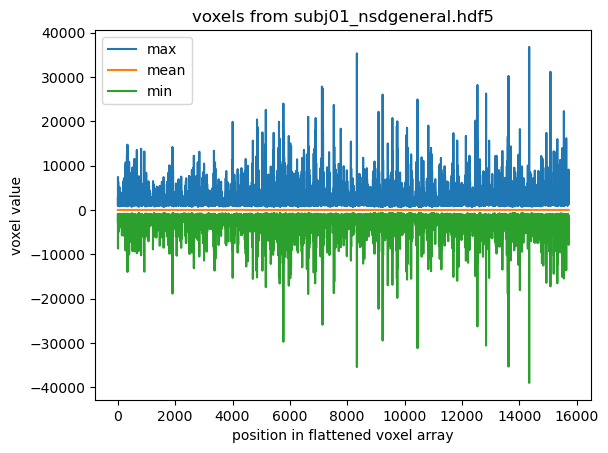

In [35]:
plt.plot(np.vstack((np.max(train_voxels, 0), np.mean(train_voxels, 0), np.min(train_voxels, 0))).T);
plt.legend(['max', 'mean', 'min']);
plt.xlabel('position in flattened voxel array');
plt.ylabel('voxel value');
plt.title(f'voxels from {subj}_nsdgeneral.hdf5');

In [36]:
import pandas as pd

In [37]:
np.mean(train_voxels)

-0.17817266

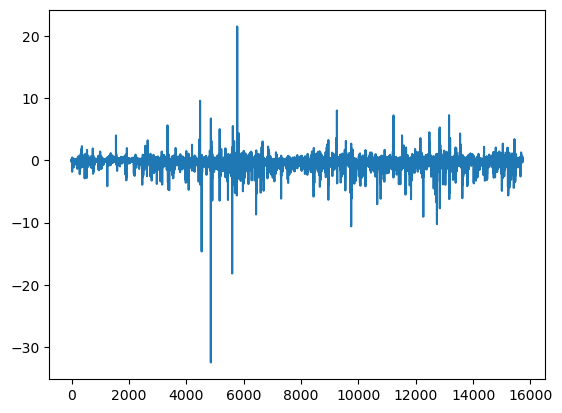

In [38]:
pd.Series(np.mean(train_voxels, 0)).plot();

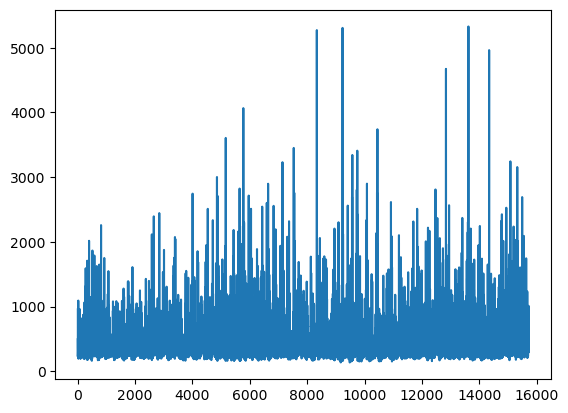

In [39]:
pd.Series(np.std(train_voxels, 0)).plot();

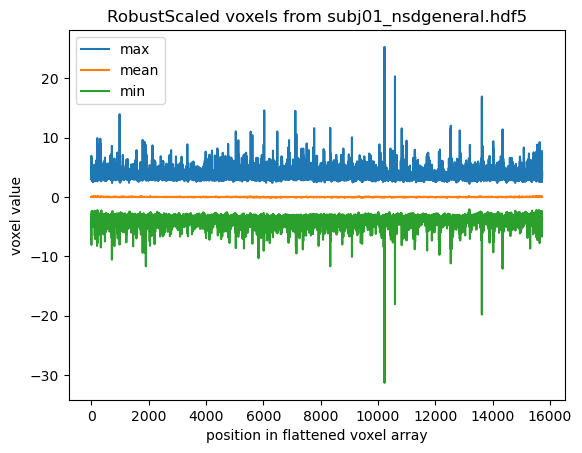

In [41]:
scale_voxels = True

if scale_voxels:
    from sklearn.preprocessing import RobustScaler

    sc_vox = RobustScaler()
    sc_vox.fit(train_voxels)

    train_voxels_sc = sc_vox.transform(train_voxels)
    val_voxels_sc = sc_vox.transform(val_voxels)

    plt.plot(np.vstack((np.max(train_voxels_sc, 0), np.mean(train_voxels_sc, 0), np.min(train_voxels_sc, 0))).T);
    plt.legend(['max', 'mean', 'min']);
    plt.xlabel('position in flattened voxel array');
    plt.ylabel('voxel value');
    plt.title(f'RobustScaled voxels from {subj}_nsdgeneral.hdf5');

In [ ]:
# embeddings don't need scaling
plt.hist(train_embs.ravel(), bins=20);

## https://github.com/drboog/Lafite

In [35]:
# Load original presented images 
f = h5py.File(os.path.join(ddir, 'subj01_nsdgeneral.hdf5'), 'r')

# train_images = torch.Tensor(f['images'][train_trials]).permute(0,3,1,2)
# val_images = torch.Tensor(f['images'][val_trials]).permute(0,3,1,2)
# val_images = val_images[exclude_repeats]

In [ ]:
f['images'][train_trials]

In [ ]:
f['images'].shape

In [ ]:
list(f.keys())

In [ ]:
train_embs = f['images'][train_trials]
val_embs = f['images'][val_trials]
print(train_embs.shape, val_embs.shape)

train_embs = train_embs[train_ind_order]
val_embs = val_embs[val_ind_order]
print(train_embs.shape, val_embs.shape)

In [ ]:
# # train_images = torch.Tensor(f['images'][train_trials]).permute(0,3,1,2)
# val_images = torch.Tensor(f['images'][val_trials]).permute(0,3,1,2)
# val_images = val_images[exclude_repeats]

In [ ]:
f.close()

# Create / Train Model

In [ ]:
32 * 512

16384

In [ ]:
import gc

def clear_mem():
    !nvidia-smi

    try:
        del voxels2emb
    except:
        pass
    try:
        del optimizer
    except:
        pass
    try:    
        del scheduler
    except:
        pass    
    try:
        del train_voxels_
    except:
        pass
    try:
        del dset_train
    except:
        pass
    try:
        del dset_val
    except:
        pass
    try:
        del data_loader
    except:
        pass
    try:
        del data_loader_val
    except:
        pass
    
    with torch.no_grad():
        torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    gc.collect()  

In [78]:
# set seeds to keep things reproducible and stay sane
torch.manual_seed(0)
np.random.seed(0)

# clear_mem()

# create network
input_size = 15724
h1 = 1024*3
voxels2emb = torch.nn.Sequential(
    torch.nn.BatchNorm1d(input_size),
    torch.nn.Linear(input_size, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Dropout(.15),  
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Dropout(.15), 
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.Linear(h1, 512*32),
).to(device)

# n_params: 127,025,880
print('n_params: {:,}'.format(param_count(voxels2emb)))
voxels2emb

n_params: 127,025,880


Sequential(
  (0): BatchNorm1d(15724, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=15724, out_features=3072, bias=True)
  (2): GELU(approximate='none')
  (3): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
  (4): Linear(in_features=3072, out_features=3072, bias=True)
  (5): GELU(approximate='none')
  (6): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
  (7): Dropout(p=0.15, inplace=False)
  (8): Linear(in_features=3072, out_features=3072, bias=True)
  (9): GELU(approximate='none')
  (10): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
  (11): Dropout(p=0.15, inplace=False)
  (12): Linear(in_features=3072, out_features=3072, bias=True)
  (13): GELU(approximate='none')
  (14): Linear(in_features=3072, out_features=16384, bias=True)
)

In [43]:
!nvidia-smi

Thu Nov  3 21:23:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   37C    P2    73W / 300W |   1187MiB / 49140MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   

In [ ]:
## smaller/simpler network for experimenting

# torch.manual_seed(0)
# np.random.seed(0)

# input_size = 15724
# output_size = 16384 # 32*512 for SG-XL
# h1 = 1024*3

# voxels2emb = torch.nn.Sequential(
#     torch.nn.Linear(input_size, h1),
#     torch.nn.ReLU(),
#     torch.nn.LayerNorm(h1), ## this is critical
#     torch.nn.Linear(h1, output_size),
# ).to(device)

# n_params: 98,661,376
# print('n_params: {:,}'.format(param_count(voxels2emb)))
# voxels2emb 

In [ ]:
# del voxels2emb
# del optimizer
# del scheduler
# del train_voxels_
# del dset_train
# del dset_val

In [ ]:
#del emb, emb_, loss, val_emb, val_emb_, val_voxel, voxel
#del data_loader, data_loader_val
#del mse

In [ ]:
# whos

In [89]:
mse = nn.MSELoss()
initial_learning_rate = .003 
# optimizer = torch.optim.AdamW(voxels2emb.parameters(), lr=initial_learning_rate)
# optimizer = torch.optim.SGD(voxels2emb.parameters(), lr=initial_learning_rate, momentum=0.95)
optimizer = torch.optim.Adam(voxels2emb.parameters(), lr=initial_learning_rate)
num_epochs = 50
#num_epochs = 1500
batch_size = 32
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=3e-6, patience=5)

if scale_voxels:
    train_voxels_ = train_voxels_sc
else:
    train_voxels_ = train_voxels

dset_train = torch.utils.data.TensorDataset(
    torch.tensor(train_voxels_).to(device), 
    torch.tensor(train_embs).to(device)
)

dset_val = torch.utils.data.TensorDataset(
    torch.tensor(val_voxels).to(device),
    torch.tensor(val_embs).to(device)
)

data_loader = torch.utils.data.DataLoader(
    dataset=dset_train, batch_size=batch_size, shuffle=True
)

# batch size is the whole val set
data_loader_val = torch.utils.data.DataLoader(
    dataset=dset_val, batch_size=len(val_voxels), shuffle=False
)

In [90]:
train_voxels_.min(), train_voxels_.max()

(-31.301807, 25.262226)

In [91]:
def plot_training():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,3))
    ax1.set_title(f"Training Loss\n(final loss={train_losses[-1]})")
    ax1.plot(train_losses)
    ax2.set_title(f"Validation Loss\n(final loss={val_losses[-1]})")
    ax2.plot(val_losses)
    ax3.set_title("Learning rate")
    ax3.plot(lrs)
    ax3.set_yscale('log')
    plt.show()

def plot_err(err):
    plt.plot(err.T);
    plt.show();

In [92]:
train_losses = []; val_losses = []; lrs = []; errs = []

pbar = tqdm(range(num_epochs))

for epoch in pbar:

    voxels2emb.train()
    batch_losses = []
    for i, (voxel, emb) in enumerate(data_loader):
        optimizer.zero_grad()
        
        emb_ = voxels2emb(voxel)
        emb_ = emb_.reshape(emb.shape)

        loss = mse(emb, emb_)
        
        #import ipdb;ipdb.set_trace()

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        batch_losses.append(loss.item())
        #break

    train_loss = np.mean(batch_losses)
    batch_losses = []
    
    # note: each validation loss is entire set, not actually batched
    voxels2emb.eval()
    for i, (val_voxel, val_emb) in enumerate(data_loader_val):
        with torch.no_grad():
            val_emb_ = voxels2emb(val_voxel)
            val_emb_ = val_emb_.reshape(val_emb.shape)
            
            loss = mse(val_emb, val_emb_)
            val_losses.append(loss.item())
            batch_losses.append(loss.item())

    val_loss = np.mean(batch_losses)

    # for ReduceLROnPlateau
    #scheduler.step(val_loss)
    
    lrs.append(optimizer.param_groups[0]['lr'])

    # print("epoch: %03d/%03d, losses: %.4f, %.4f" % \
    #       (epoch+1, num_epochs, train_loss, val_loss))
    
    err = ((val_emb - val_emb_)**2).reshape(-1, 32*512).cpu().numpy()
    #plot_err(err)
    err_sum = err.sum()
    errs.append(err_sum);
    pbar.set_postfix({'train_loss': train_loss, 'val_loss': val_loss, 'lr': lrs[-1], 'err': err_sum})

 24%|████████████████████████████▊                                                                                           | 12/50 [03:54<12:21, 19.53s/it, train_loss=0.45, val_loss=0.501, lr=0.003, err=3.29e+5]


KeyboardInterrupt: 

In [93]:
loss

tensor(0.4567, device='cuda:0', grad_fn=<MseLossBackward0>)

In [99]:
err.sum() / err.shape[0] / err.shape[1]

0.5014222621917724

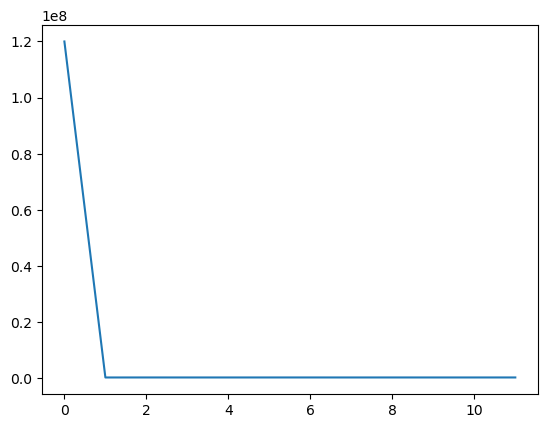

In [101]:
plt.plot(errs);

In [53]:
val_emb.shape

torch.Size([40, 32, 512])

In [68]:
err = (val_emb - val_emb_).reshape(-1, 32*512)
err.shape

torch.Size([40, 16384])

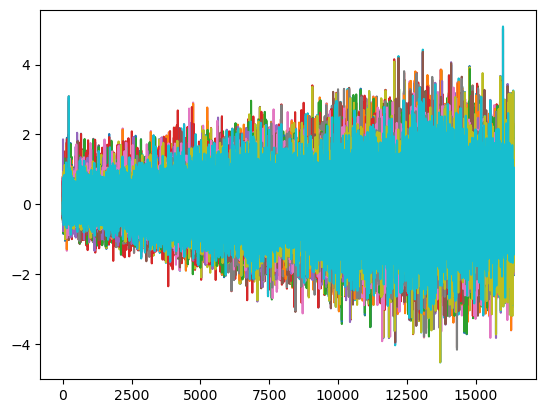

In [71]:
plt.plot(err.cpu().numpy().T);

In [ ]:
plt.hist(

In [50]:
voxel.shape

torch.Size([32, 15724])

In [51]:
voxel.min(), voxel.mean(), voxel.max()

(tensor(-35335.5586, device='cuda:0'),
 tensor(-6.1910, device='cuda:0'),
 tensor(30199.4434, device='cuda:0'))

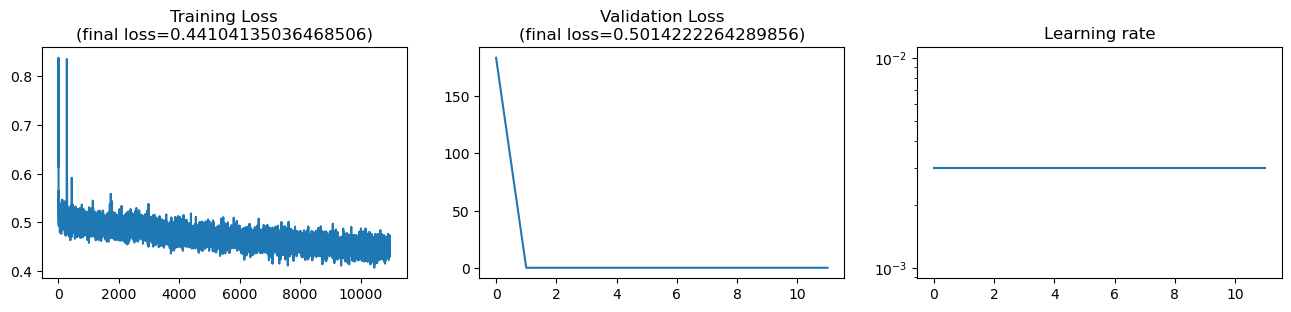

In [102]:
# orig network, one batch, no scaling
plot_training()

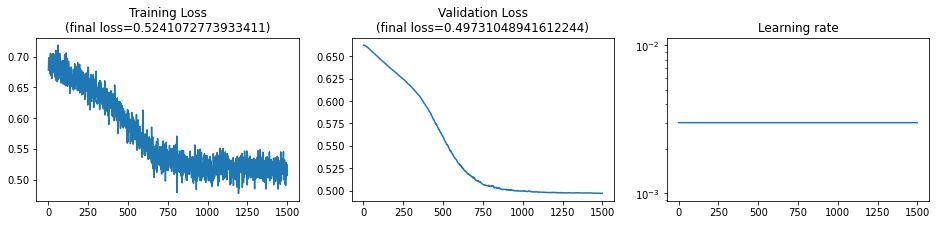

In [ ]:
# orig network, one batch, no scaling
plot_training()

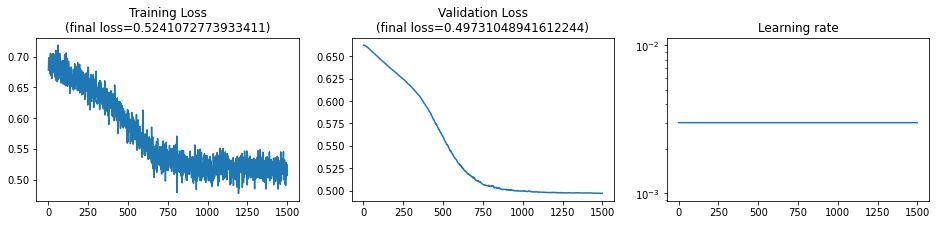

In [ ]:
# orig network, one batch, no scaling
plot_training()

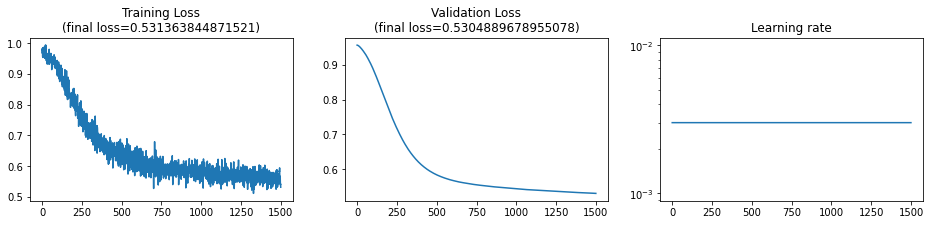

In [ ]:
# small w/ layer norm network, one batch
plot_training()

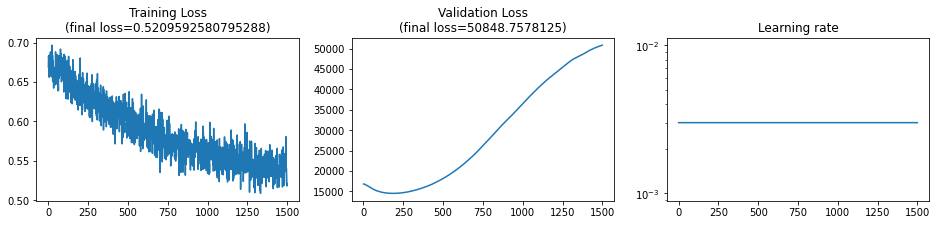

In [ ]:
# small network w/o layer norm, one batch
plot_training()

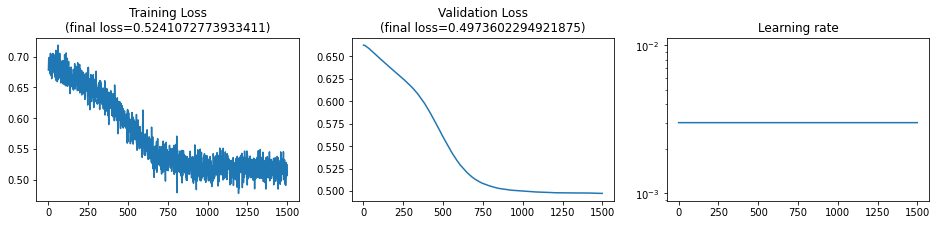

In [ ]:
# big network, one batch
plot_training()

# Save/Load Model

In [ ]:
# Saving
torch.save({
            'epoch': epoch,
            'model_state_dict': voxels2emb.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, os.path.join(ddir, 'voxels2emb.pth'))

In [ ]:
# Loading 
checkpoint = torch.load(os.path.join(ddir, 'voxels2emb.pth'))

voxels2emb.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

# Visualize reconstructions
Note: you may need to restart kernel, load the model you saved in the above cell, and then run the following cells

In [ ]:
# Load StyleGAN-XL
!git clone https://github.com/autonomousvision/stylegan_xl
#!wget https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl

fatal: destination path 'stylegan_xl' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/drboog/Lafite
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 4.01 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 './Lafite']

In [ ]:
sys.path.append('./Lafite')

In [ ]:
sys.path.append('stylegan2-ada-pytorch')

In [ ]:
#sys.path.append('./stylegan_xl')
#!pip install ninja
#!pip install timm ftfy 
import dnnlib
import legacy

In [ ]:
#!pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip
!pip install "git+https://github.com/openai/CLIP.git@main#egg=clip"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git (to revision main) to /tmp/pip-install-hck5887p/clip_43d4dde30f094d699b89f164d173b19a
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-install-hck5887p/clip_43d4dde30f094d699b89f164d173b19a
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=9b942dbabea855dba4855b53d471e466f01be84a5774d1644528a63243fc1660
  Stored in directory: /tmp/pip-ephem-wheel-cache-oocdz3n_/wheels/4f/8c/7a/734a584b1039fd503ab2a1faec145caa3df56e020157675f63
Successfully built clip
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Can't uninstall 'clip'. No files were found to uninstall.


In [ ]:
import clip

In [ ]:
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 4.2 MB/s 


In [ ]:
class Generator:
    def __init__(self, device, path):
        self.name = 'generator'
        self.model = self.load_model(device, path)
        self.device = device
        self.force_32 = False
        
    def load_model(self, device, path):
        with dnnlib.util.open_url(path) as f:
            network= legacy.load_network_pkl(f)
            self.G_ema = network['G_ema'].to(device)
            self.D = network['D'].to(device)
#                 self.G = network['G'].to(device)
            return self.G_ema
        
    def generate(self, z, c, fts, noise_mode='const', return_styles=True):
        return self.model(z, c, fts=fts, noise_mode=noise_mode, return_styles=return_styles, force_fp32=self.force_32)
    
    def generate_from_style(self, style, noise_mode='const'):
        ws = torch.randn(1, self.model.num_ws, 512)
        return self.model.synthesis(ws, fts=None, styles=style, noise_mode=noise_mode, force_fp32=self.force_32)
    
    def tensor_to_img(self, tensor):
        img = torch.clamp((tensor + 1.) * 127.5, 0., 255.)
        img_list = img.permute(0, 2, 3, 1)
        img_list = [img for img in img_list]
        return PIL.Image.fromarray(torch.cat(img_list, dim=-2).detach().cpu().numpy().astype(np.uint8))

In [90]:
# Visit links and download (or add shortcuts to your gdrive to download inside colab)
# Gaussian:
# https://drive.google.com/file/d/1eNkuZyleGJ3A3WXTCIGYXaPwJ6NH9LRA/view
# NN:
# https://drive.google.com/file/d/1WQnlCM4pQZrw3u9ZeqjeUNqHuYfiDEU3/view

#weights_path = '/content/drive/MyDrive/AI/neuro/COCO2014_Language-free_Gaussian.pkl'
weights_path = '/content/drive/MyDrive/AI/neuro/COCO2014_Language-free-NN.pkl'
!du -h $weights_path

456M	/content/drive/MyDrive/AI/neuro/COCO2014_Language-free-NN.pkl


In [ ]:
with torch.no_grad():

    device = 'cuda:0' # please use GPU, do not use CPU
    path = weights_path
    generator = Generator(device=device, path=path)
    clip_model, _ = clip.load("ViT-B/32", device=device)
    clip_model = clip_model.eval()
    
    txt = 'a man riding on a horse'  # input sentence
    tokenized_text = clip.tokenize([txt]).to(device)
    txt_fts = clip_model.encode_text(tokenized_text)
    txt_fts = txt_fts/txt_fts.norm(dim=-1, keepdim=True)
    
    z = torch.randn((1, 512)).to(device)
    c = torch.randn((1, 1)).to(device) # label is actually not used
    img, _ = generator.generate(z=z, c=c, fts=txt_fts)
    to_show_img = generator.tensor_to_img(img)
    to_show_img.save('./generated.jpg')

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


./Lafite/torch_utils/ops/upfirdn2d.py:27: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "./Lafite/torch_utils/ops/upfirdn2d.py", line 25, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "./Lafite/torch_utils/custom_ops.py", line 103, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py", line 1214, in load
    keep_intermediates=keep_intermediates)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py", line 1450, in _jit_compile
    return _import_module_from_library(name, build_directory, is_python_module)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py", line 1844, in _import_module_from_library
    modu

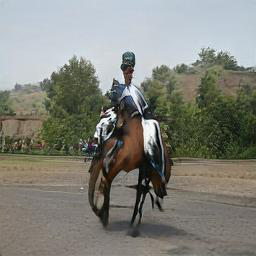

In [94]:
PIL.Image.open('./generated.jpg')

In [ ]:
# Load pretrained model
network_pkl = 'imagenet256.pkl'
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
print('Using device:', device, file=sys.stderr)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema']
    G = G.eval().requires_grad_(False).to(device)  

Loading networks from "imagenet256.pkl"...


Using device: cuda


ImportError: ignored

In [ ]:
# Load original presented images 
f = h5py.File(os.path.join(ddir, 'subj01_nsdgeneral.hdf5'), 'r')
# train_images = torch.Tensor(f['images'][train_trials]).permute(0,3,1,2)
val_images = torch.Tensor(f['images'][val_trials]).permute(0,3,1,2)
val_images = val_images[exclude_repeats]
f.close()

In [ ]:
# Depict original image / projection (i.e., best possible reconstruction) / reconstruction
voxels2emb.eval()

with torch.no_grad():
    emb_ = voxels2emb(torch.tensor(val_voxels)[:8].to(device)).reshape([8,32,512])
    
    for i in range(8):
        pic = G.synthesis(torch.tensor(val_embs)[i].unsqueeze(0).to(device), noise_mode='const')
        pic_ = G.synthesis(emb_[i].unsqueeze(0).to(device), noise_mode='const')
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,6))
        ax[0].imshow(torch_to_matplotlib(val_images[i].unsqueeze(0)))
        ax[1].imshow(torch_to_matplotlib(pic))
        ax[2].imshow(torch_to_matplotlib(pic_))
        ax[0].set_title("original\nimage")
        ax[0].axis("off")
        ax[1].set_title("latent\nprojection")
        ax[1].axis("off")
        ax[2].set_title("neural\nreconstruction")
        ax[2].axis("off")

In [ ]:
# Depict original image / projection (i.e., best possible reconstruction) / reconstruction
voxels2emb.eval()

n = 20

with torch.no_grad():
    emb_ = voxels2emb(torch.tensor(val_voxels)[:n].to(device)).reshape([n,32,512])
    
    for i in range(n):
        pic = G.synthesis(torch.tensor(val_embs)[i].unsqueeze(0).to(device), noise_mode='const')
        pic_ = G.synthesis(emb_[i].unsqueeze(0).to(device), noise_mode='const')
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,6))
        ax[0].imshow(torch_to_matplotlib(val_images[i].unsqueeze(0)))
        ax[1].imshow(torch_to_matplotlib(pic))
        ax[2].imshow(torch_to_matplotlib(pic_))
        ax[0].set_title("original\nimage")
        ax[0].axis("off")
        ax[1].set_title("latent\nprojection")
        ax[1].axis("off")
        ax[2].set_title("neural\nreconstruction")
        ax[2].axis("off")

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
imgs = [torch_to_Image(val_images[i].unsqueeze(0), rescale=False) for i in range(40)]
image_grid(imgs, 10, 4)